# Freddie Mac residential mortgage data set

- Thomas Butler (vra2cf)
- Andrej Erkelens (wsw3fa)
- Matt Suozzi (mds5dd)

Freddie Mac has public data sets of residential mortgages dating back to January 1, 1999. The data is available on a quarterly basis in two files: origination and performance. The origination data maintains 31 features about the loan as of the closing date, including: first payment date, credit score, debt-to-income, loan-to-value, interest rate, amortization type, property type, and geography. The performance data maintains 31 features of the loan as of March 31, 2021, including: delinquency status, loan age, months to maturity, estimated loan-to-value, actual loss, delinquency due to disaster, and others. The two files can be joined on a common feature - Loan Sequence Number.

In early 2020, the Covid-19 pandemic impacted the US economy, as quarantine rules kept many people home from work. Even though increasing unemployment rates created uncertainty and caution of a potential recession, the housing market boomed in highly desirable locations of the country due to the acceptance of remote work.

We will combine quarterly files from Q1 2019 through Q3 2020, with loan payment history and delinquency status as of Q1 2021. The combined data set will provide insight into features that cause delinquency and the impact from the Covid-19 pandemic.

For the project, the group will explore the following questions:

 - Predict delinquencies: (Primary Question)
     - What features impact delinquency?
     - What is the average time to delinquency?
     - What is the average loss given delinquency?
 - Impact from the pandemic?
 - Which areas of the US will have a high level of single family loans in the next 12 months?
     - Evaluate the # and $ of loans and the change in values/volume in certain areas. Since the data spans from pre-covid through the first 6 months it would be interesting to see the shift (i.e. NYC -> FL/TX)

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
spark = SparkSession.builder \
    .master("local[5]") \
    .config("spark.driver.memory",'4g') \
    .getOrCreate()

import pandas as pd

### Load data files
Create two Spark DataFrames for origination and monthly performance data. Combine files. 
Can later join data on Loan Sequence Number.

In [2]:
#need to make [First_Payment_Date, Maturity_Date] into a date type
# Schema for origination data files (31 columns)
schema = StructType([StructField('Credit_Score', IntegerType(), True),  #Potential predictor variable
                     StructField('First_Payment_Date', StringType(), True), # EDA time 
                     StructField('First_Time_Homebuyer_Flag', StringType(), True),
                     StructField('Maturity_Date', StringType(), True), 
                     StructField('Metropolitan_Statistical_Area_or_Metropolitan_Division', IntegerType(), True), 
                     StructField('Mortgage_Insurance_Percentage(MI%)', IntegerType(), True),
                     StructField('Number_of_Units', IntegerType(), True),
                     StructField('Occupancy_Status', StringType(), True),
                     StructField('Original_Combined_Loan-to-Value_CLTV', IntegerType(), True), #Potential predictor variable
                     StructField('Original_Debt-to-Income_DTI_Ratio', IntegerType(), True), #Potential predictor variable
                     StructField('Original_UPB', IntegerType(), True),
                     StructField('Original_Loan-to-Value(LTV)', IntegerType(), True),
                     StructField('Original_Interest_Rate', FloatType(), True),
                     StructField('Channel', StringType(), True),
                     StructField('Prepayment_Penalty_Mortgage(PPM)_Flag', StringType(), True),
                     StructField('Amortization_Type', StringType(), True),
                     StructField('Property_State', StringType(), True),
                     StructField('Property_Type', StringType(), True),
                     StructField('Postal_Code', IntegerType(), True), # Can convert Code to Name or Map?
                     StructField('Loan_Sequence_Number', StringType(), True), # Join
                     StructField('Loan_Purpose', StringType(), True), #Potential predictor variable
                     StructField('Original_Loan_Term', IntegerType(), True),
                     StructField('Number_of_Borrowers', StringType(), True),
                     StructField('Seller_Name', StringType(), True),
                     StructField('Servicer_Name', StringType(), True),
                     StructField('Super_Conforming_Flag', StringType(), True),
                     StructField('Pre_Harp_Loan_Sequence_Number', StringType(), True),
                     StructField('Program_Indicator', StringType(), True),
                     StructField('Harp_Indicator', StringType(), True),
                     StructField('Property_Valuation_Method', IntegerType(), True),
                     StructField('Interest_Only_Indicator(I/O_Indicator)', StringType(), True)]
                   )

df = spark.read.options(delimiter="|")\
.schema(schema)\
.csv("/project/ds5559/Group_6_Housing/DS-5110-Final-Project/historical_data_2019Q1.txt") # origination_files[0]

In [3]:
# Schema for performance data files (31 columns)
schema_perf = StructType([StructField('Loan_Sequence_Number', StringType(), True),
                     StructField('Monthly_Reporting_Period', StringType(), True), # Date Type
                     StructField('Current_Actual_UPB', IntegerType(), True), # Float
                     StructField('Current_Loan_Delinquency_Status', StringType(), True), #***Response Variable for Deliquency Question****
                     StructField('Loan_Age', IntegerType(), True),
                     StructField('Remaining_Months_to_Legal_Maturity', IntegerType(), True),
                     StructField('Repurchase_Flag', StringType(), True),
                     StructField('Modification_Flag', StringType(), True),
                     StructField('Zero_Balance_Code', IntegerType(), True),
                     StructField('Zero_Balance_Effective_Date', IntegerType(), True), # Date Type
                     StructField('Current_Interest_Rate', FloatType(), True),# Float
                     StructField('Current_Deferred_UPB', IntegerType(), True),
                     StructField('Due_Date_of_Last_Paid_Installment (DDLPI)', IntegerType(), True), # Date
                     StructField('MI Recoveries', IntegerType(), True), # Float
                     StructField('Net_Sales_Proceeds', StringType(), True), # U for Unknown or Float
                     StructField('Non MI Recoveries', IntegerType(), True), # Float
                     StructField('Expenses', IntegerType(), True), # Float
                     StructField('Legal_Costs', IntegerType(), True), # Float
                     StructField('Maintenance_and_Preservation_Costs', IntegerType(), True), # Float
                     StructField('Taxes_and_Insurance', IntegerType(), True), # Float
                     StructField('Miscellaneous_Expenses', IntegerType(), True), # Float
                     StructField('Actual_Loss_Calculation', IntegerType(), True), # Float
                     StructField('Modification_Cost', IntegerType(), True), # Float
                     StructField('Step_Modification_Flag', StringType(), True),
                     StructField('Deferred_Payment_Plan', StringType(), True),
                     StructField('Estimated_Loan_to_Value', IntegerType(), True), # Float
                     StructField('Zero_Balance_Removal_UPB', IntegerType(), True),
                     StructField('Delinquent_Accrued_Interest', IntegerType(), True),
                     StructField('Delinquency_Due_to_Disaster', StringType(), True), # Consider removing these as outliers
                     StructField('Borrower_Assistance_Status_Code', StringType(), True),
                     StructField('Current_Month_Modification_Cost', IntegerType(), True)]
                   )

df2 = spark.read.options(delimiter="|")\
.schema(schema_perf)\
.csv("/project/ds5559/Group_6_Housing/DS-5110-Final-Project/historical_data_time_2019Q1.txt") # performance_files[0]

In [36]:
df_perf.columns

['Loan_Sequence_Number',
 'Monthly_Reporting_Period',
 'Current_Actual_UPB',
 'Current_Loan_Delinquency_Status',
 'Loan_Age',
 'Remaining_Months_to_Legal_Maturity',
 'Repurchase_Flag',
 'Modification_Flag',
 'Zero_Balance_Code',
 'Zero_Balance_Effective_Date',
 'Current_Interest_Rate',
 'Current_Deferred_UPB',
 'Due_Date_of_Last_Paid_Installment (DDLPI)',
 'MI Recoveries',
 'Net_Sales_Proceeds',
 'Non MI Recoveries',
 'Expenses',
 'Legal_Costs',
 'Maintenance_and_Preservation_Costs',
 'Taxes_and_Insurance',
 'Miscellaneous_Expenses',
 'Actual_Loss_Calculation',
 'Modification_Cost',
 'Step_Modification_Flag',
 'Deferred_Payment_Plan',
 'Estimated_Loan_to_Value',
 'Zero_Balance_Removal_UPB',
 'Delinquent_Accrued_Interest',
 'Delinquency_Due_to_Disaster',
 'Borrower_Assistance_Status_Code',
 'Current_Month_Modification_Cost',
 'Current_Loan_Delinquency_Status_Cat',
 'Monthly_Reporting_Period_TS',
 'Monthly_Reporting_Period_TS_num',
 'Reporting_Year',
 'Reporting_Month']

In [4]:
print(type(df))
print(df.count(), len(df.columns))

print(type(df2))
print(df2.count(), len(df2.columns))

<class 'pyspark.sql.dataframe.DataFrame'>
281046 31
<class 'pyspark.sql.dataframe.DataFrame'>
5449876 31


In [4]:
# list of the data files
directory = "/project/ds5559/Group_6_Housing/DS-5110-Final-Project/"
origination_files = ["historical_data_2019Q1.txt", "historical_data_2019Q2.txt", "historical_data_2019Q3.txt", "historical_data_2019Q4.txt", "historical_data_2020Q1.txt", "historical_data_2020Q2.txt", "historical_data_2020Q3.txt"]
performance_files = ["historical_data_time_2019Q1.txt", "historical_data_time_2019Q2.txt", "historical_data_time_2019Q3.txt", "historical_data_time_2019Q4.txt", "historical_data_time_2020Q1.txt", "historical_data_time_2020Q2.txt", "historical_data_time_2020Q3.txt"]


In [5]:
# Size of each file and cumulative count
size = 0
total = 0
file_count = pd.DataFrame(columns=['size'])
for i in range(len(origination_files)):
    data = spark.read.options(delimiter="|")\
            .schema(schema)\
            .csv(directory+origination_files[i], header = True)
    size = data.count() # don't measure distinct().count()
    total += size
    print(size, total)   

281045 281045
414828 695873
542968 1238841
545531 1784372
517499 2301871
925663 3227534
1186319 4413853


In [5]:
# Combine all files
df_orig = df
for i in range(1,len(origination_files)):
    df_orig = df_orig.union(spark.read.options(delimiter="|")\
            .schema(schema)\
            .csv(directory+origination_files[i], header = True))

In [8]:
# Check combined file with cumulative size
print(df_orig.count(), len(df_orig.columns))

4413854 31


In [9]:
# Size of each file and cumulative count
size = 0
total = 0
for i in range(len(performance_files)):
    data = spark.read.options(delimiter="|")\
            .schema(schema)\
            .csv(directory+performance_files[i], header = True)
    size = data.count() # don't measure distinct().count()
    total += size
    print(size, total)

5449875 5449875
7486618 12936493
9015236 21951729
7877345 29829074
6168481 35997555
8865475 44863030
8161444 53024474


In [6]:
# Combine all files
df_perf = df2
for i in range(1,len(performance_files)):
    df_perf = df_perf.union(spark.read.options(delimiter="|")\
            .schema(schema_perf)\
            .csv(directory+performance_files[i], header = True))

In [8]:
# Check combined file with cumulative size
print(df_perf.count(), len(df_perf.columns))

53024475 31


### Exploratory Data Analysis

To Do:
Statistical summary: originations (count, over time, by geography, by seller/servicer), credit score, debt-to-income, LTV

Correlation of delinquency status and actual loss

Statistical Summary: Response Variable

We need to make larger categories for the response variable or make it a numeric variable but what do we put for the defaulted loans? (RA)

Making categories for 0, past due, Deliquent.

Explore the number of delinquencies from disaster (and as a proportion of overall delinquencies).

In [7]:
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
#How to do summary on Numeric Column
#df_perf.select("Current_Loan_Delinquency_Status").summary().show()

total = df_perf.count()
num_lis = [str(num) for num in range(1,26)]

#Making new categories for Current_Loan_Delinquency_Status
df_perf = df_perf.withColumn("Current_Loan_Delinquency_Status_Cat", when(df_perf.Current_Loan_Delinquency_Status.isin(num_lis), "Past_Due").\
                             when(df_perf.Current_Loan_Delinquency_Status == "R","Deliquent").\
                            otherwise(df_perf.Current_Loan_Delinquency_Status))
#Summary on Categorical Column
response_cat = df_perf.select("Current_Loan_Delinquency_Status_Cat").\
                groupBy('Current_Loan_Delinquency_Status_Cat').\
                agg(F.count('Current_Loan_Delinquency_Status_Cat').alias("Current_Loan_Delinquency_Status_count")).\
                withColumn("Percent", col('Current_Loan_Delinquency_Status_count')/total*100)

response_cat.show()

+-----------------------------------+-------------------------------------+--------------------+
|Current_Loan_Delinquency_Status_Cat|Current_Loan_Delinquency_Status_count|             Percent|
+-----------------------------------+-------------------------------------+--------------------+
|                                  0|                             51983637|    98.0370611873102|
|                          Deliquent|                                   44|8.298054813366847E-5|
|                           Past_Due|                              1040794|  1.9628558321416665|
+-----------------------------------+-------------------------------------+--------------------+



In [14]:
#Numeric Response Variable, remove all loans that have alread defaulted.
response_num = df_perf.filter(df_perf.Current_Loan_Delinquency_Status != "R")

#recast response variable as int type.
response_num = response_num.withColumn("Current_Loan_Delinquency_Status_num", response_num["Current_Loan_Delinquency_Status"].cast(IntegerType())).\
                                        drop("Current_Loan_Delinquency_Status")
response_num.select("Current_Loan_Delinquency_Status_num").summary().show()

+-------+-----------------------------------+
|summary|Current_Loan_Delinquency_Status_num|
+-------+-----------------------------------+
|  count|                           53024431|
|   mean|                0.06854570490346233|
| stddev|                  0.631948389520299|
|    min|                                  0|
|    25%|                                  0|
|    50%|                                  0|
|    75%|                                  0|
|    max|                                 25|
+-------+-----------------------------------+



In [17]:
summary_cols = ['Original_UPB', 'Original_Combined_Loan-to-Value_CLTV','Original_Loan_Term','Original_Interest_Rate']

df_orig.select(*summary_cols).summary().show()

+-------+------------------+------------------------------------+------------------+----------------------+
|summary|      Original_UPB|Original_Combined_Loan-to-Value_CLTV|Original_Loan_Term|Original_Interest_Rate|
+-------+------------------+------------------------------------+------------------+----------------------+
|  count|           4413854|                             4413854|           4413854|               4413854|
|   mean|274836.89967996225|                    73.0423330721859| 322.2726839175016|    3.5965916045151074|
| stddev|136876.31969977848|                  17.334214262459096|  70.5439242088245|    0.6973193761271437|
|    min|              1000|                                   6|                84|                  1.75|
|    25%|            171000|                                  63|               360|                   3.0|
|    50%|            252000|                                  75|               360|                   3.5|
|    75%|            358000|

array([[<AxesSubplot:title={'center':'Original_UPB'}>]], dtype=object)

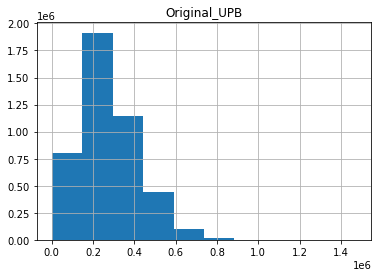

In [18]:
# Histogram of loan balances
df_orig.select('Original_UPB').toPandas().hist()

In [15]:
# Breaking out features for EDA purposes - not really necessary
quant_features = ['Credit_Score', 'Original_Debt-to-Income_DTI_Ratio', 'Original_Combined_Loan-to-Value_CLTV', 'Original_Loan_Term']
cat_features_orig = ["First_Time_Homebuyer_Flag", "Occupancy_Status", "Loan_Purpose", "Number_of_Borrowers"]
loan_terms = ['Original_Interest_Rate', 'Amortization_Type']
quant_features_perf = ["Current_Interest_Rate", "Loan_Age", "Remaining_Months_to_Legal_Maturity"]
cat_features_perf = ["Modification_Flag"]

In [16]:
df_orig_quant = df_orig.select('Credit_Score', 'Original_Debt-to-Income_DTI_Ratio', 'Original_Combined_Loan-to-Value_CLTV', "Original_Loan_Term", 
                               'Original_Interest_Rate')
df_perf_quant= df_perf.select('Current_Interest_Rate', "Loan_Age", "Remaining_Months_to_Legal_Maturity")

In [17]:
df_orig_quant.summary().show()

+-------+------------------+---------------------------------+------------------------------------+------------------+----------------------+
|summary|      Credit_Score|Original_Debt-to-Income_DTI_Ratio|Original_Combined_Loan-to-Value_CLTV|Original_Loan_Term|Original_Interest_Rate|
+-------+------------------+---------------------------------+------------------------------------+------------------+----------------------+
|  count|           4413854|                          4413854|                             4413854|           4413854|               4413854|
|   mean| 758.0140213065498|               34.269540859303454|                    73.0423330721859| 322.2726839175016|    3.5965916045151074|
| stddev|162.53575254058413|               19.041083383378663|                  17.334214262459096|  70.5439242088245|    0.6973193761271437|
|    min|               309|                                1|                                   6|                84|                  1.75|
|    2

In [18]:
total = df_orig.count()
df_orig.filter(df_orig["Original_Debt-to-Income_DTI_Ratio"] == 999).count()/total *100

0.02890897614646973

In [19]:
df_orig.filter(df_orig["Original_Combined_Loan-to-Value_CLTV"] == 999).count()/total*100

0.0015632596819015762

In [20]:
df_perf_quant.summary().show()

+-------+---------------------+-----------------+----------------------------------+
|summary|Current_Interest_Rate|         Loan_Age|Remaining_Months_to_Legal_Maturity|
+-------+---------------------+-----------------+----------------------------------+
|  count|             53024475|         53024475|                          53024475|
|   mean|   3.7909002440887694|6.737731905879313|                  317.883591813026|
| stddev|   0.7073987366708038|5.251733742385626|                 69.00840856183055|
|    min|                 1.75|                0|                                71|
|    25%|                 3.25|                3|                               342|
|    50%|                 3.75|                6|                               352|
|    75%|                 4.25|               10|                               356|
|    max|                  7.0|               25|                               480|
+-------+---------------------+-----------------+----------------

In [21]:
total = df_orig.count()
Homebuyer_cat = df_orig.select("First_Time_Homebuyer_Flag").\
                groupBy('First_Time_Homebuyer_Flag').\
                agg(F.count('First_Time_Homebuyer_Flag').alias("First_Time_Homebuyer_Flag_count")).\
                withColumn("Percent", col('First_Time_Homebuyer_Flag_count')/total*100)
Homebuyer_cat.show()

+-------------------------+-------------------------------+------------------+
|First_Time_Homebuyer_Flag|First_Time_Homebuyer_Flag_count|           Percent|
+-------------------------+-------------------------------+------------------+
|                        Y|                         705563|15.985191173065536|
|                        N|                         822093| 18.62528756048569|
|                        9|                        2886198| 65.38952126644878|
+-------------------------+-------------------------------+------------------+



In [22]:
Occupancy_Status_cat = df_orig.select("Occupancy_Status").\
                groupBy('Occupancy_Status').\
                agg(F.count('Occupancy_Status').alias("Occupancy_Status_count")).\
                withColumn("Percent", col('Occupancy_Status_count')/total*100)
Occupancy_Status_cat.show()

+----------------+----------------------+------------------+
|Occupancy_Status|Occupancy_Status_count|           Percent|
+----------------+----------------------+------------------+
|               S|                162656| 3.685124156802649|
|               I|                225747|5.1145099044961615|
|               P|               4025451| 91.20036593870118|
+----------------+----------------------+------------------+



In [23]:
Loan_Purpose_cat = df_orig.select("Loan_Purpose").\
                groupBy('Loan_Purpose').\
                agg(F.count('Loan_Purpose').alias("Loan_Purpose_count")).\
                withColumn("Percent", col('Loan_Purpose_count')/total*100)
Loan_Purpose_cat.show()

+------------+------------------+------------------+
|Loan_Purpose|Loan_Purpose_count|           Percent|
+------------+------------------+------------------+
|           C|            865854|19.616734037872572|
|           N|           1806142|40.919840121580826|
|           P|           1741858|39.463425840546606|
+------------+------------------+------------------+



In [24]:
Number_of_Borrowers_cat = df_orig.select("Number_of_Borrowers").\
                groupBy('Number_of_Borrowers').\
                agg(F.count('Number_of_Borrowers').alias("Number_of_Borrowers_count")).\
                withColumn("Percent", col('Number_of_Borrowers_count')/total*100)
Number_of_Borrowers_cat.show()

+-------------------+-------------------------+-----------------+
|Number_of_Borrowers|Number_of_Borrowers_count|          Percent|
+-------------------+-------------------------+-----------------+
|                 01|                  2288623|51.85089946337147|
|                 02|                  2125231|48.14910053662854|
+-------------------+-------------------------+-----------------+



In [25]:
#Looks like " " didn't translate into a value.
df_perf = df_perf.withColumn("Modification_Flag", when(df_perf.Modification_Flag.isNull(), "N").otherwise(df_perf.Modification_Flag))

total = df_perf.count()
Modification_Flag_cat = df_perf.select("Modification_Flag").\
                groupBy('Modification_Flag').\
                agg(F.count('Modification_Flag').alias("Modification_Flag_count")).\
                withColumn("Percent", col('Modification_Flag_count')/total*100)
Modification_Flag_cat.show()

+-----------------+-----------------------+------------------+
|Modification_Flag|Modification_Flag_count|           Percent|
+-----------------+-----------------------+------------------+
|                Y|                   1075|0.0020273656646294|
|                N|               53023400| 99.99797263433537|
+-----------------+-----------------------+------------------+



Clean up outliers for Credit Score > 850, DTI > 65, CLTV > 200

Look at scatter plots...

In [26]:
# Histograms of Credit Score, DTI, LTV, Original Loan Term and Current Interest Rate
df_quant_sp = df_orig_quant.toPandas() #.hist(figsize=(6,4))

In [27]:
df_quant_sp.head()

,Credit_Score,Original_Debt-to-Income_DTI_Ratio,Original_Combined_Loan-to-Value_CLTV,Original_Loan_Term,Original_Interest_Rate
0,758,14,55,240,4.375
1,768,36,52,360,3.875
2,798,49,80,360,4.750
3,789,43,39,120,3.625
4,782,26,80,360,4.875


In [28]:
df_quant_sp.columns

Index(['Credit_Score', 'Original_Debt-to-Income_DTI_Ratio',
       'Original_Combined_Loan-to-Value_CLTV', 'Original_Loan_Term',
       'Original_Interest_Rate'],
      dtype='object')

### Cleaning up the columns

In [29]:
df_quant_sp = df_quant_sp[~(df_quant_sp.Credit_Score > 850)]

In [30]:
df_quant_sp['Original_Debt-to-Income_DTI_Ratio'].value_counts()

45     181043
44     177967
43     170060
42     163634
41     160391
40     157856
39     156196
38     153616
37     151351
36     150017
35     147532
34     146221
33     143773
32     141594
31     138929
30     135109
29     131921
28     128228
27     123308
26     118722
25     112568
24     106218
49     102646
46     100425
23      99904
48      97805
47      97550
50      93415
22      91833
21      84730
20      75973
19      67854
18      59437
17      51515
16      43705
15      36247
14      29234
13      23348
12      17821
11      13329
10       9400
9        6535
8        4500
7        2936
6        1849
999      1273
5        1228
4         763
3         502
2         323
1         234
51          6
53          2
54          2
61          1
52          1
55          1
56          1
60          1
Name: Original_Debt-to-Income_DTI_Ratio, dtype: int64

In [31]:
# 999 clear outlier, removing all above 100 which will remove those
df_quant_sp = df_quant_sp[~(df_quant_sp['Original_Debt-to-Income_DTI_Ratio'] > 100)]

In [32]:
cltv_dict = dict(zip(df_quant_sp['Original_Combined_Loan-to-Value_CLTV'].value_counts().index,df_quant_sp['Original_Combined_Loan-to-Value_CLTV'].value_counts()))

In [33]:
import collections
cltv_sorted_d = collections.OrderedDict(sorted(cltv_dict.items()))

In [34]:
cltv_sorted_d

OrderedDict([(6, 76),
             (7, 150),
             (8, 222),
             (9, 323),
             (10, 510),
             (11, 596),
             (12, 853),
             (13, 1074),
             (14, 1354),
             (15, 1637),
             (16, 2125),
             (17, 2368),
             (18, 2832),
             (19, 3153),
             (20, 3902),
             (21, 3924),
             (22, 4649),
             (23, 5238),
             (24, 5810),
             (25, 6544),
             (26, 6503),
             (27, 7554),
             (28, 8401),
             (29, 9011),
             (30, 10393),
             (31, 10301),
             (32, 11672),
             (33, 11729),
             (34, 13496),
             (35, 14255),
             (36, 14689),
             (37, 15354),
             (38, 17188),
             (39, 17589),
             (40, 20879),
             (41, 18345),
             (42, 20884),
             (43, 22352),
             (44, 23266),
             (45, 2495

### Again 999 is a clear outlier, removing all above 500 which will remove these

In [35]:
df_quant_sp = df_quant_sp[~(df_quant_sp['Original_Combined_Loan-to-Value_CLTV'] > 500)]

In [36]:
loan_term_dict = dict(zip(df_quant_sp['Original_Loan_Term'].value_counts().index,df_quant_sp['Original_Loan_Term'].value_counts()))

In [37]:
loan_term_dict_sorted = collections.OrderedDict(sorted(loan_term_dict.items()))

In [38]:
loan_term_dict_sorted

OrderedDict([(85, 9),
             (86, 1),
             (90, 2),
             (96, 557),
             (98, 1),
             (100, 3),
             (101, 1),
             (104, 2),
             (105, 2),
             (107, 3),
             (108, 111),
             (109, 1),
             (111, 2),
             (112, 1),
             (115, 3),
             (116, 2),
             (118, 1),
             (119, 3),
             (120, 30375),
             (121, 85),
             (122, 2),
             (123, 3),
             (125, 2),
             (126, 5),
             (127, 1),
             (128, 1),
             (129, 1),
             (130, 2),
             (131, 4),
             (132, 1293),
             (133, 3),
             (134, 4),
             (135, 6),
             (136, 1),
             (137, 2),
             (138, 10),
             (139, 7),
             (140, 20),
             (141, 12),
             (142, 11),
             (143, 7),
             (144, 3687),
             (145, 9

In [39]:
(df_quant_sp['Original_Interest_Rate'].value_counts().min(),df_quant_sp['Original_Interest_Rate'].value_counts().max())

(1, 325791)

In [40]:
orig_int_dict = dict(zip(df_quant_sp['Original_Interest_Rate'].value_counts().index,df_quant_sp['Original_Interest_Rate'].value_counts()))

In [41]:
orig_int_sort = collections.OrderedDict(sorted(orig_int_dict.items()))

In [42]:
# these appear to be normal
(df_quant_sp['Original_Interest_Rate'].min(),df_quant_sp['Original_Interest_Rate'].max())

(1.75, 7.0)

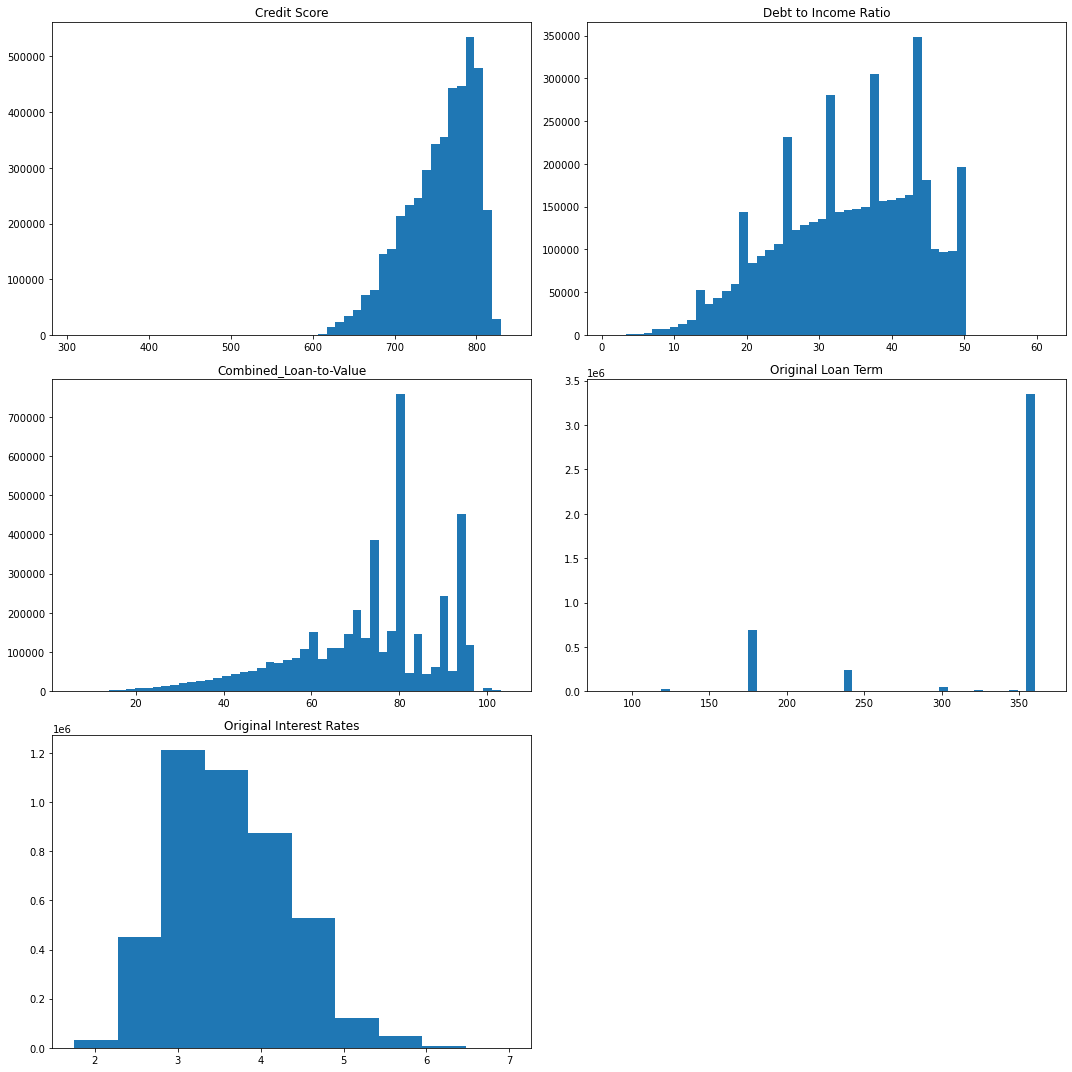

In [43]:
fig, ax = plt.subplots(3, 2,figsize=(15,15))
fig.delaxes(ax[2,1]) 
ax[0,0].hist(df_quant_sp['Credit_Score'],bins=50)
ax[0,0].title.set_text('Credit Score')
ax[0,1].hist(df_quant_sp['Original_Debt-to-Income_DTI_Ratio'],bins=50)
ax[0,1].title.set_text('Debt to Income Ratio')
ax[1,0].hist(df_quant_sp['Original_Combined_Loan-to-Value_CLTV'],bins=50)
ax[1,0].title.set_text('Combined_Loan-to-Value')
ax[1,1].hist(df_quant_sp['Original_Loan_Term'],bins=50)
ax[1,1].title.set_text('Original Loan Term')
ax[2,0].hist(df_quant_sp['Original_Interest_Rate'])
ax[2,0].title.set_text('Original Interest Rates')
fig.tight_layout()

Consider converting Credit Score into a categorical variable: {'High Credit': >800, 'Very Good': 740-799, 'Good': 670-739, 'Fair': 580-669, 'Poor':300-579}

### Added categorical on a 4,3,2,1,0 grouping as per indications above --> if we want to pursue this option

In [44]:
df2 = df.withColumn('Credit_Score', when(df.Credit_Score >= 800, 4).when((df.Credit_Score < 800)&(df.Credit_Score >= 740),3).\
                    when((df.Credit_Score < 740)&(df.Credit_Score >= 670),2).when((df.Credit_Score < 670)&(df.Credit_Score >= 580),1).\
                    when((df.Credit_Score < 580),0))

In [45]:
df2.select('Credit_Score').show(10)

+------------+
|Credit_Score|
+------------+
|           3|
|           3|
|           3|
|           3|
|           3|
|           3|
|           1|
|           1|
|           3|
|           3|
+------------+
only showing top 10 rows



In [46]:
df_credit_grouped = df2.toPandas()

(array([5.20000e+01, 1.89560e+04, 9.25150e+04, 1.39175e+05, 3.03480e+04]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

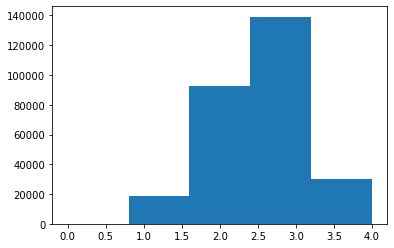

In [47]:
plt.hist(df_credit_grouped['Credit_Score'],bins=5)

In [48]:
df_credit_grouped["Credit_Score"]

0         3
1         3
2         3
3         3
4         3
         ..
281041    2
281042    4
281043    3
281044    3
281045    2
Name: Credit_Score, Length: 281046, dtype: int32

array([[<AxesSubplot:title={'center':'Current_Interest_Rate'}>,
        <AxesSubplot:title={'center':'Loan_Age'}>],
       [<AxesSubplot:title={'center':'Remaining_Months_to_Legal_Maturity'}>,
        <AxesSubplot:>]], dtype=object)

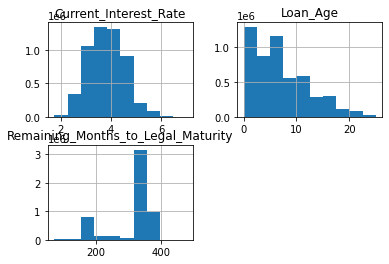

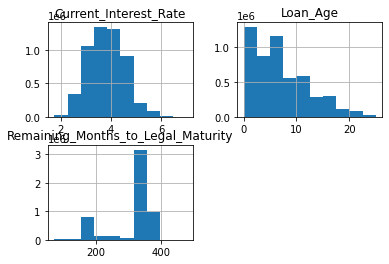

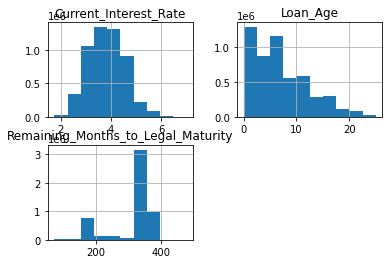

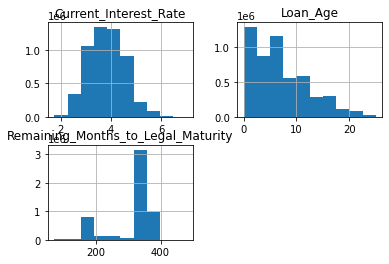

In [49]:
#Histogram of Original Interest Rate and Loan Age
#Have to sample because dataframe is too big
#They all look similar so this should be a representative sample.
df_perf_quant.sample(fraction=0.1, seed=314).toPandas().hist()

df_perf_quant.sample(fraction=0.1, seed=628).toPandas().hist()

df_perf_quant.sample(fraction=0.1, seed=10).toPandas().hist()

df_perf_quant.sample(fraction=0.1, seed=3).toPandas().hist()

## Clean Performance File

Loans have multiple records for each payment period.

A single loan could potentially have mutliple current and/or delinquent records.

In [27]:
# Convert to Date Types (needs to be StringType first)
df_perf = df_perf.withColumn('Monthly_Reporting_Period_TS', to_timestamp(col('Monthly_Reporting_Period'), 'yyyyMM'))
df_perf = df_perf.withColumn('Monthly_Reporting_Period_TS_num', df_perf['Monthly_Reporting_Period_TS'].cast(IntegerType()))
df_perf = df_perf.withColumn('Reporting_Year', year('Monthly_Reporting_Period_TS'))
df_perf = df_perf.withColumn('Reporting_Month', month('Monthly_Reporting_Period_TS'))

df_perf.select('Monthly_Reporting_Period', 'Monthly_Reporting_Period_TS_num', "Monthly_Reporting_Period_TS", 'Reporting_Year', 'Reporting_Month').show(5)

+------------------------+-------------------------------+---------------------------+--------------+---------------+
|Monthly_Reporting_Period|Monthly_Reporting_Period_TS_num|Monthly_Reporting_Period_TS|Reporting_Year|Reporting_Month|
+------------------------+-------------------------------+---------------------------+--------------+---------------+
|                  201904|                     1554076800|        2019-04-01 00:00:00|          2019|              4|
|                  201905|                     1556668800|        2019-05-01 00:00:00|          2019|              5|
|                  201906|                     1559347200|        2019-06-01 00:00:00|          2019|              6|
|                  201907|                     1561939200|        2019-07-01 00:00:00|          2019|              7|
|                  201908|                     1564617600|        2019-08-01 00:00:00|          2019|              8|
+------------------------+------------------------------

In [10]:
# Filter for only delinquent loans
df_perf_delinq = df_perf.filter(df_perf.Current_Loan_Delinquency_Status_Cat!="0")
df_perf_delinq.count()

1040838

There are over 1 million payment periods where a loan is delinquent.

In [42]:
# Take the first reporting period that a loan was marked delinquent
df_perf_delinq_min = df_perf_delinq.select("Loan_Sequence_Number","Monthly_Reporting_Period_TS","Monthly_Reporting_Period_TS_num").groupBy("Loan_Sequence_Number").min("Monthly_Reporting_Period_TS_num").alias("Monthly_Reporting_Period_TS_num")
df_perf_delinq_min = df_perf_delinq_min.select(df_perf_delinq_min.Loan_Sequence_Number, df_perf_delinq_min["min(Monthly_Reporting_Period_TS_num)"].alias("Monthly_Reporting_Period_TS_num"))
df_perf_delinq_min = df_perf.join(broadcast(df_perf_delinq_min), ['Loan_Sequence_Number', 'Monthly_Reporting_Period_TS_num'], "inner") \
    .drop('Current_Actual_UPB', 'Current_Loan_Delinquency_Status', 'Loan_Age', 'Remaining_Months_to_Legal_Maturity', 'Repurchase_Flag', 'Modification_Flag', 'Zero_Balance_Code', 'Zero_Balance_Effective_Date', 'Current_Interest_Rate', 'Current_Deferred_UPB', 'Due_Date_of_Last_Paid_Installment (DDLPI)', 'MI Recoveries', 'Net_Sales_Proceeds', 'Non MI Recoveries', 'Expenses', 'Legal_Costs', 'Maintenance_and_Preservation_Costs', 'Taxes_and_Insurance', 'Miscellaneous_Expenses', 'Actual_Loss_Calculation', 'Modification_Cost',  'Step_Modification_Flag', 'Deferred_Payment_Plan', 'Estimated_Loan_to_Value', 'Zero_Balance_Removal_UPB', 'Delinquent_Accrued_Interest', 'Delinquency_Due_to_Disaster', 'Borrower_Assistance_Status_Code', 'Current_Month_Modification_Cost', 'Current_Loan_Delinquency_Status_Cat', 'Reporting_Year', 'Reporting_Month')

In [41]:
df_perf_delinq_min.show(5)

+--------------------+-------------------------------+---------------------------+
|Loan_Sequence_Number|Monthly_Reporting_Period_TS_num|Monthly_Reporting_Period_TS|
+--------------------+-------------------------------+---------------------------+
|        F19Q10000009|                     1569888000|        2019-10-01 00:00:00|
|        F19Q10000033|                     1585699200|        2020-04-01 00:00:00|
|        F19Q10000040|                     1567296000|        2019-09-01 00:00:00|
|        F19Q10000044|                     1612137600|        2021-02-01 00:00:00|
|        F19Q10000049|                     1585699200|        2020-04-01 00:00:00|
+--------------------+-------------------------------+---------------------------+
only showing top 5 rows



In [11]:
# Take the most recent reporting period for each delinquent loan
df_perf_delinq = df_perf_delinq.groupBy("Loan_Sequence_Number").max("Monthly_Reporting_Period_TS_num").alias("Monthly_Reporting_Period_TS_num")
df_perf_delinq = df_perf_delinq.select(df_perf_delinq.Loan_Sequence_Number, df_perf_delinq["max(Monthly_Reporting_Period_TS_num)"].alias("Monthly_Reporting_Period_TS_num"))


259375

In [ ]:
df_perf_delinq.count()

In [18]:
df_perf_delinq_all = df_perf.join(broadcast(df_perf_delinq), ['Loan_Sequence_Number', 'Monthly_Reporting_Period_TS_num'], "inner") \
    .drop("Monthly_Reporting_Period_TS","Monthly_Reporting_Period_TS_num","Reporting_Year","Reporting_Month","Current_Actual_UPB","Repurchase_Flag","Zero_Balance_Code",
          "Zero_Balance_Effective_Date","Current_Deferred_UPB","Due_Date_of_Last_Paid_Installment (DDLPI)","MI Recoveries","Expenses","Legal_Costs","Maintenance_and_Preservation_Costs",
         "Taxes_and_Insurance","Miscellaneous_Expenses","Modification_Cost","Step_Modification_Flag","Deferred_Payment_Plan","Estimated_Loan_to_Value",
         "Zero_Balance_Removal_UPB","Delinquency_Due_to_Disaster","Borrower_Assistance_Status_Code","Current_Month_Modification_Cost","Net_Sales_Proceeds",
         "Non MI Recoveries")
df_perf_delinq_all.cache()

In [ ]:
df_perf_delinq_all.count()

Those 1,040,838 delinquent periods are related to 259,375 distinct loans. 

In [14]:
df_perf_newest_loan = df_perf.groupBy("Loan_Sequence_Number").max("Monthly_Reporting_Period_TS_num")
df_perf_newest_loan = df_perf_newest_loan.select(df_perf_newest_loan.Loan_Sequence_Number, df_perf_newest_loan["max(Monthly_Reporting_Period_TS_num)"].alias("Monthly_Reporting_Period_TS_num"))


In [48]:
df_perf_newest_loan.count()

4413774

In [19]:
df_perf_newest_loan_all = df_perf.join(df_perf_newest_loan, ['Loan_Sequence_Number', 'Monthly_Reporting_Period_TS_num'], "inner") \
    .drop("Monthly_Reporting_Period_TS","Monthly_Reporting_Period_TS_num","Reporting_Year","Reporting_Month","Current_Actual_UPB","Repurchase_Flag","Zero_Balance_Code",
          "Zero_Balance_Effective_Date","Current_Deferred_UPB","Due_Date_of_Last_Paid_Installment (DDLPI)","MI Recoveries","Expenses","Legal_Costs","Maintenance_and_Preservation_Costs",
         "Taxes_and_Insurance","Miscellaneous_Expenses","Modification_Cost","Step_Modification_Flag","Deferred_Payment_Plan","Estimated_Loan_to_Value",
         "Zero_Balance_Removal_UPB","Delinquency_Due_to_Disaster","Borrower_Assistance_Status_Code","Current_Month_Modification_Cost","Net_Sales_Proceeds",
         "Non MI Recoveries")
df_perf_newest_loan_all.cache()


DataFrame[Loan_Sequence_Number: string, Monthly_Reporting_Period: string, Current_Loan_Delinquency_Status: string, Loan_Age: int, Remaining_Months_to_Legal_Maturity: int, Modification_Flag: string, Current_Interest_Rate: float, Actual_Loss_Calculation: int, Delinquent_Accrued_Interest: int, Current_Loan_Delinquency_Status_Cat: string]

In [49]:
df_perf_newest_loan_all.count()

4413774

Total distinct loans of over 4.4 million. So the delinquency rate is approximately 5.9%.

In [16]:
#df_perf.select("Loan_Sequence_Number").distinct().count()
#4413774

In [17]:
df_perf_delinq_all.columns == df_perf_newest_loan_all.columns

True

In [15]:
df_perf_newest_loan_all.columns

['Loan_Sequence_Number',
 'Monthly_Reporting_Period',
 'Current_Loan_Delinquency_Status',
 'Loan_Age',
 'Remaining_Months_to_Legal_Maturity',
 'Modification_Flag',
 'Current_Interest_Rate',
 'Actual_Loss_Calculation',
 'Delinquent_Accrued_Interest',
 'Current_Loan_Delinquency_Status_Cat']

In [20]:
deliq_Loan_Num = df_perf_delinq_all.select(collect_list("Loan_Sequence_Number")).first()[0]
delinq_Loan_Num.cache()

In [21]:
#Filter out all the Loan Numbers that have been identified as delinquent
df_perf_current = df_perf_newest_loan_all.filter(~df_perf_newest_loan_all.Loan_Sequence_Number.isin(deliq_Loan_Num))
df_perf_current.cache()


DataFrame[Loan_Sequence_Number: string, Monthly_Reporting_Period: string, Current_Loan_Delinquency_Status: string, Loan_Age: int, Remaining_Months_to_Legal_Maturity: int, Modification_Flag: string, Current_Interest_Rate: float, Actual_Loss_Calculation: int, Delinquent_Accrued_Interest: int, Current_Loan_Delinquency_Status_Cat: string]

In [50]:
df_perf_current.count()

4154399

In [21]:
4413774-259375

4154399

In [22]:
# Union of most recent records for delinquent and current loans
df_perf_clean = df_perf_current.union(df_perf_delinq_all)
df_perf_clean.cache()

DataFrame[Loan_Sequence_Number: string, Monthly_Reporting_Period: string, Current_Loan_Delinquency_Status: string, Loan_Age: int, Remaining_Months_to_Legal_Maturity: int, Modification_Flag: string, Current_Interest_Rate: float, Actual_Loss_Calculation: int, Delinquent_Accrued_Interest: int, Current_Loan_Delinquency_Status_Cat: string]

In [19]:
df_perf_clean.columns

['Loan_Sequence_Number',
 'Monthly_Reporting_Period',
 'Current_Loan_Delinquency_Status',
 'Loan_Age',
 'Remaining_Months_to_Legal_Maturity',
 'Modification_Flag',
 'Current_Interest_Rate',
 'Actual_Loss_Calculation',
 'Delinquent_Accrued_Interest',
 'Current_Loan_Delinquency_Status_Cat']

In [31]:
df_perf_clean.count()

4413774

In [23]:
# Calculate ratio of delinquency vs. current in clean data set
df_perf_clean.groupBy("Current_Loan_Delinquency_Status_Cat").agg(F.count('Current_Loan_Delinquency_Status_Cat').alias("Current_Loan_Delinquency_Status_count")).\
                withColumn("Percent", col('Current_Loan_Delinquency_Status_count')/total*100)

DataFrame[Current_Loan_Delinquency_Status_Cat: string, Current_Loan_Delinquency_Status_count: bigint, Percent: double]

In [42]:
#Remove outliers in data.
df_orig = df_orig[~(df_orig.Credit_Score > 850)]
df_orig = df_orig[~(df_orig['Original_Debt-to-Income_DTI_Ratio'] > 100)]
df_orig = df_orig[~(df_orig['Original_Combined_Loan-to-Value_CLTV'] > 500)]


In [43]:
#joining dataframes.
df_full = df_orig.join(df_perf_clean, ["Loan_Sequence_Number"],'inner')

In [44]:
#Total size of full dataframe
total = df_full.count()
print(total, len(df_full.columns))

4411156 40


In [51]:
#Check for duplicate rows in full dataframe
df_test = df_full.groupBy("Loan_Sequence_Number").count().filter("count > 1")

#Should we drop these? 0% are dupicate Loan numbers.
x = df_test.drop('count').count()
print(x)
print("Total % dropped " + str(x/total*100))

0
Total % dropped 0.0


### Is there a change in interest rate, if so how has it changed?

In [45]:
#numeric interest rate change
df_full = df_full.withColumn("Change_of_Interest_Rate", df_full.Original_Interest_Rate-df_full.Current_Interest_Rate)

In [52]:
#most loans don't have a change in interest rate
Interest_Rate_Changed_num = df_full
Change_of_Interest_Rate= Interest_Rate_Changed_num.select('Change_of_Interest_Rate')
Change_of_Interest_Rate.summary().show()

+-------+-----------------------+
|summary|Change_of_Interest_Rate|
+-------+-----------------------+
|  count|                4411156|
|   mean|   1.765351297118605E-4|
| stddev|   0.016912036005392105|
|    min|                 -0.125|
|    25%|                    0.0|
|    50%|                    0.0|
|    75%|                    0.0|
|    max|                  3.625|
+-------+-----------------------+



In [53]:
#filter out 0
Interest_Rate_Changed_num = Interest_Rate_Changed_num.filter(Interest_Rate_Changed_num.Change_of_Interest_Rate != 0)
Change_of_Interest_Rate= Interest_Rate_Changed_num.select('Change_of_Interest_Rate')
Change_of_Interest_Rate.summary().show()

+-------+-----------------------+
|summary|Change_of_Interest_Rate|
+-------+-----------------------+
|  count|                    560|
|   mean|     1.3905785654272351|
| stddev|     0.5657577206863769|
|    min|                 -0.125|
|    25%|                    1.0|
|    50%|                  1.375|
|    75%|                   1.75|
|    max|                  3.625|
+-------+-----------------------+



array([[<AxesSubplot:title={'center':'Change_of_Interest_Rate'}>]],
      dtype=object)

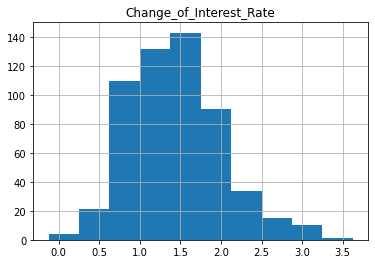

In [72]:
#Histogram of Change of Interest Rate with 0 filtered out.
Change_of_Interest_Rate.toPandas().hist()

Put these variables into a df to save.

Response: Current_Loan_Delinquency_Status

Predictors:

Origination Data File:

Credit_Score

First_Time_Homebuyer_Flag

Occupancy_Status

Original_Combined_Loan-to-Value_CLTV

Original_Debt-to-Income_DTI_Ratio

Original_Interest_Rate

Loan_Purpose

Original_Loan_Term

Number_of_Borrowers

Monthly perfomance data files:

Loan_Age

Remaining_Months_to_Legal_Maturity

Actual_Loss_Calculation

Delinquent_Accrued_Interest

Modification_Flag

Change_of_Interest_Rate -- Change to difference in interest rate.

In [46]:
col_lis= ["Current_Loan_Delinquency_Status", "Current_Loan_Delinquency_Status_Cat", "Credit_Score", "First_Time_Homebuyer_Flag", "Occupancy_Status", "Original_Combined_Loan-to-Value_CLTV",
          "Original_Debt-to-Income_DTI_Ratio", "Original_Interest_Rate", "Loan_Purpose", "Original_Loan_Term", "Number_of_Borrowers", "Loan_Age", 'Actual_Loss_Calculation',"Delinquent_Accrued_Interest", "Remaining_Months_to_Legal_Maturity",
         "Modification_Flag", "Change_of_Interest_Rate"]
df_model_1 = df_full.select(*col_lis)


In [47]:
#Write df into a file.
df_model_1.write.mode('overwrite').parquet("/project/ds5559/Group_6_Housing/DS-5110-Final-Project/df_model_1.parquet")

In [74]:
# Convert to Date Types (needs to be StringType first)
df_orig = df_orig.withColumn('First_Payment_TS', to_timestamp(col('First_Payment_Date'), 'yyyyMM'))
df_orig = df_orig.withColumn('First_Payment_Year', year('First_Payment_TS'))
df_orig = df_orig.withColumn('First_Payment_Month', month('First_Payment_TS'))

df_orig.select('First_Payment_Date', 'First_Payment_TS', 'First_Payment_Year', 'First_Payment_Month').show(5)

+------------------+-------------------+------------------+-------------------+
|First_Payment_Date|   First_Payment_TS|First_Payment_Year|First_Payment_Month|
+------------------+-------------------+------------------+-------------------+
|            201905|2019-05-01 00:00:00|              2019|                  5|
|            201905|2019-05-01 00:00:00|              2019|                  5|
|            201903|2019-03-01 00:00:00|              2019|                  3|
|            201904|2019-04-01 00:00:00|              2019|                  4|
|            201903|2019-03-01 00:00:00|              2019|                  3|
+------------------+-------------------+------------------+-------------------+
only showing top 5 rows



In [75]:
# number loans originated each month
df_orig_TS = df_orig.select('First_Payment_TS').groupBy('First_Payment_TS').count().orderBy('First_Payment_TS').toPandas()

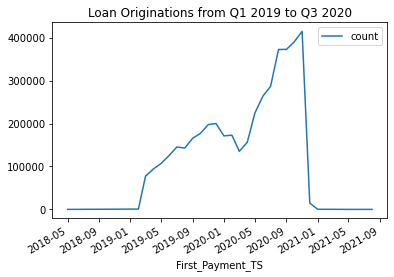

In [76]:
# Graph
df_orig_TS.plot(x='First_Payment_TS', y='count')
plt.title('Loan Originations from Q1 2019 to Q3 2020')
plt.show()

New loans decline in the beginning of 2020 until May, then rapidly increase to new highs.

In [77]:
# Group by state
df_orig_state = df_orig.select('Property_State').groupBy('Property_State').count().orderBy('count', ascending=False).toPandas()

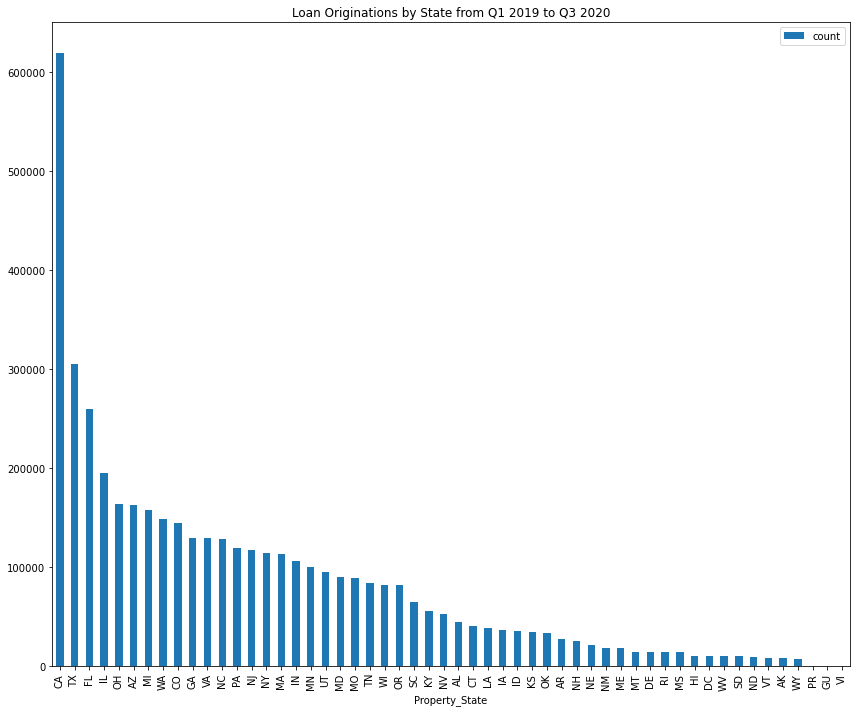

In [78]:

from matplotlib.pyplot import figure

# Bar graph
df_orig_state.plot(kind='bar', x='Property_State', y='count',figsize=(12, 10))

plt.title('Loan Originations by State from Q1 2019 to Q3 2020')
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tight_layout()
plt.show()

California, Texas, and Florida are the 3 highest states for loan originations. 

Where does New York rank?

In [79]:
# Combine time and state for top 3 states
df_orig_grouped = df_orig.select('First_Payment_TS', 'Property_State')\
    .where((col('Property_State')=='CA')|(col('Property_State')=='TX')|(col('Property_State')=='FL')|(col('Property_State')=='NY'))\
    .groupBy('Property_State','First_Payment_TS')\
    .count()\
    .orderBy('First_Payment_TS').toPandas()

High loan origination at the new year in 2021!

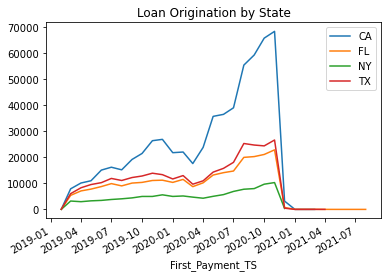

In [80]:
fig,ax = plt.subplots()
for k,v in df_orig_grouped.groupby('Property_State'):
    v.plot(x='First_Payment_TS',y='count', ax=ax,label=k)

plt.title('Loan Origination by State')
plt.show()

In [50]:
# number loans originated each month
df_delinq_TS = df_perf_delinq_min.select('Monthly_Reporting_Period_TS').groupBy('Monthly_Reporting_Period_TS').count().orderBy('Monthly_Reporting_Period_TS').toPandas()

In [ ]:
df_delinq_TS.head(5)

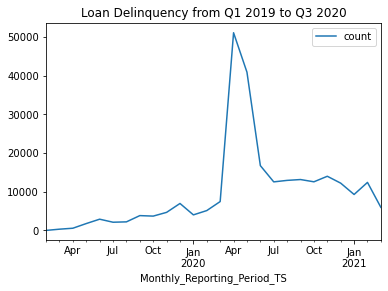

In [51]:
# Graph
df_delinq_TS.plot(x='Monthly_Reporting_Period_TS', y='count')
plt.title('Loan Delinquency from Q1 2019 to Q3 2020')
plt.show()

In [48]:
df_perf_period=df_perf_delinq_min.select('Monthly_Reporting_Period').groupBy('Monthly_Reporting_Period').count().orderBy('count', ascending=False).toPandas()

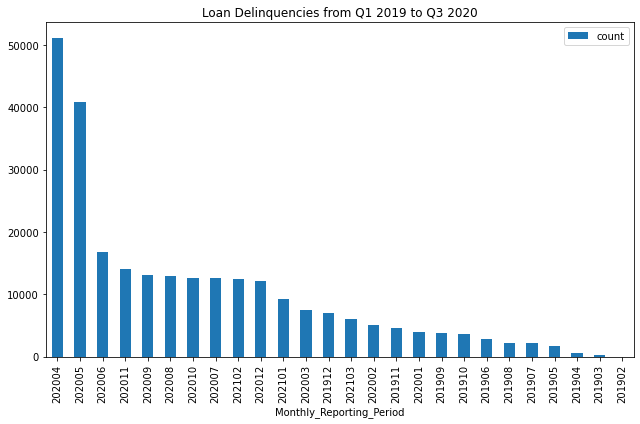

In [49]:
# Bar graph
df_perf_period.plot(kind='bar', x='Monthly_Reporting_Period', y='count',figsize=(9, 6))

plt.title('Loan Delinquencies from Q1 2019 to Q3 2020')
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tight_layout()
plt.show()

Loan delinquencies increased in April, May, and June 2020, during the early portions of Covid-19.

How to calculate loan delinquency rate over time?

 - Loans from an origination First_Payment period that became delinquent in a Monthly_Reporting_Period
 
Should we split the data for model building for pre-pandemic?